In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
results_file = 'configurations/RS11_11_cluster5_4_merged.json'

# Loading Results

In [3]:
def json_results_to_dataframe(json_data):
    experiments = []
    metadata = json_data['metadata']

    for exp in json_data['experiments']:
        # Skip experiments with no results
        if exp['total_reward'] is None or exp['total_discounted_reward'] is None:
            continue

        # For each run in the experiment
        for run_idx, (total_reward, discounted_reward) in enumerate(zip(
            exp['total_reward'], exp['total_discounted_reward'])):

            exp_data = {
                'experiment_id': exp['experiment_id'],
                'env_instance_id': exp['env_instance_id'],
                'state_id': exp['state_id'],
                'help_config_id': exp['help_config_id'],
                'rover_position': str(exp['rover_position']),
                'rock_locations': str(exp['rock_locations']),
                'rock_types': str(exp['rock_types']),
                'help_actions': str(exp['help_actions']),
                'total_reward': total_reward,
                'total_discounted_reward': discounted_reward,
                'run_id': run_idx
            }
            experiments.append(exp_data)

    df = pd.DataFrame(experiments)
    return df, metadata

In [4]:
with open(results_file) as f:
    json_data = json.load(f)

df, metadata = json_results_to_dataframe(json_data)
df

,experiment_id,env_instance_id,state_id,help_config_id,rover_position,rock_locations,rock_types,help_actions,total_reward,total_discounted_reward,run_id
0,0,0,0,-1,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...",{},50.0,21.970854,0
1,0,0,0,-1,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...",{},50.0,21.473110,1
2,0,0,0,-1,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...",{},40.0,19.465957,2
3,1,0,0,0,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...","{'1': [0, -4], '7': [-5, -1], '10': [-1, -6]}",60.0,15.239265,0
4,1,0,0,0,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...","{'1': [0, -4], '7': [-5, -1], '10': [-1, -6]}",20.0,3.754686,1
...,...,...,...,...,...,...,...,...,...,...,...
52345,17448,9,49,46,"[0, 3]","{'(0, 6)': 0, '(6, 4)': 1, '(4, 1)': 2, '(3, 4...","['good', 'good', 'bad', 'good', 'good', 'good'...","{'8': [-8, -8], '9': [-6, -5], '10': [-4, -7]}",50.0,23.053259,1
52346,17448,9,49,46,"[0, 3]","{'(0, 6)': 0, '(6, 4)': 1, '(4, 1)': 2, '(3, 4...","['good', 'good', 'bad', 'good', 'good', 'good'...","{'8': [-8, -8], '9': [-6, -5], '10': [-4, -7]}",60.0,26.225925,2
52347,17449,9,49,47,"[0, 3]","{'(0, 6)': 0, '(6, 4)': 1, '(4, 1)': 2, '(3, 4...","['good', 'good', 'bad', 'good', 'good', 'good'...","{'9': [-5, 1], '10': [-5, 0], '8': [-8, -3]}",40.0,22.647330,0
52348,17449,9,49,47,"[0, 3]","{'(0, 6)': 0, '(6, 4)': 1, '(4, 1)': 2, '(3, 4...","['good', 'good', 'bad', 'good', 'good', 'good'...","{'9': [-5, 1], '10': [-5, 0], '8': [-8, -3]}",60.0,24.804602,1


In [5]:
instances_count = df.groupby('env_instance_id').agg({
    'state_id': 'nunique',
    'help_config_id': 'nunique'
}).reset_index()

# Check which instances have complete experiments (15 states and at least 10 help configs) (that's almost complete instances)
complete_instances = instances_count[
    (instances_count['state_id'] >= 20) &
    (instances_count['help_config_id'] >= 10)
]['env_instance_id'].tolist()

print(f"Number of instances: {len(instances_count)}")
print(f"Number of complete instances: {len(complete_instances)}")

# Filter for complete instances only
df_complete = df[df['env_instance_id'].isin(complete_instances)]

# Count experiments with less than 3 runs
experiment_runs = df_complete.groupby(['env_instance_id', 'state_id', 'help_config_id']).size().reset_index(name='run_count')

print(f"\nNumber of experiments with at least 3 runs: {len(experiment_runs[experiment_runs['run_count'] >= 3])}")
print(f"Number of experiments with less than 3 runs: {len(experiment_runs[experiment_runs['run_count'] < 3])}")
print(f"Number of experiments with less than 2 runs: {len(experiment_runs[experiment_runs['run_count'] < 2])}")
print(f"Number of experiments with less than 1 runs: {len(experiment_runs[experiment_runs['run_count'] < 1])}")

env_instances_ids = df_complete['env_instance_id'].unique()
print(f"complete instances: {env_instances_ids}")

Number of instances: 10
Number of complete instances: 10

Number of experiments with at least 3 runs: 17450
Number of experiments with less than 3 runs: 0
Number of experiments with less than 2 runs: 0
Number of experiments with less than 1 runs: 0
complete instances: [0 1 2 3 4 5 6 7 8 9]


In [6]:
# env_instances_to_analyze = [0,]
env_instances_to_analyze = env_instances_ids

df_complete = df_complete[df_complete['env_instance_id'].isin(env_instances_to_analyze)]

# Statistics

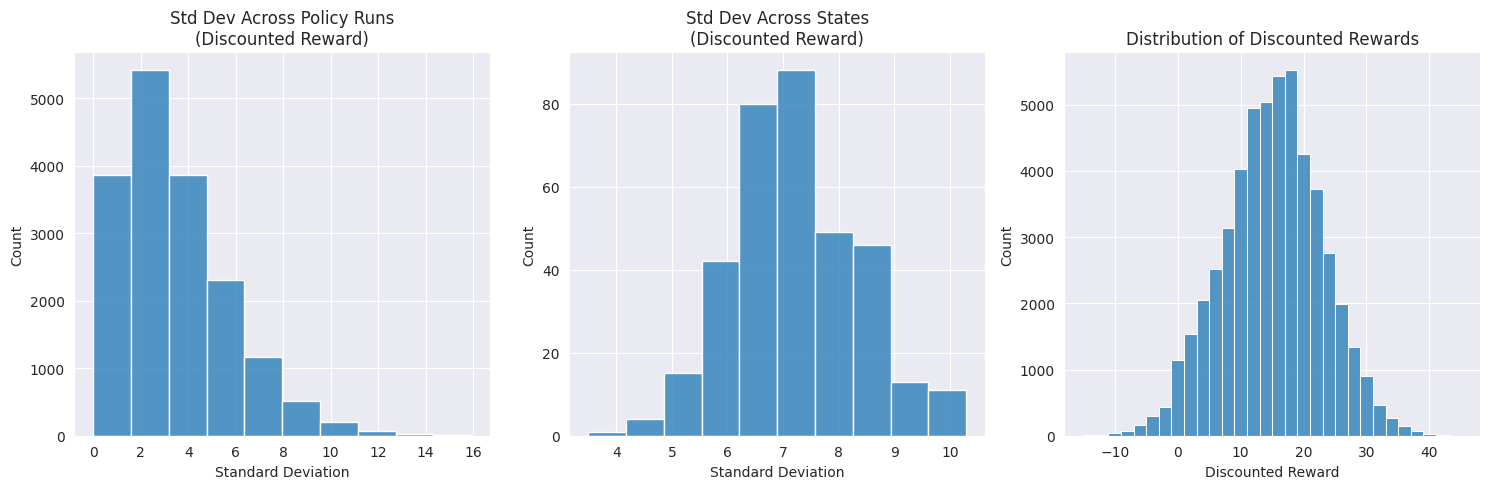


Policy StdDev Statistics (Discounted Reward):
count    17450.000000
mean         3.465032
std          2.302750
min          0.000000
25%          1.727581
50%          3.005555
75%          4.744421
max         15.915433
Name: policy_std, dtype: float64

State StdDev Statistics (Discounted Reward):
count    349.000000
mean       7.214087
std        1.135774
min        3.495703
25%        6.438960
50%        7.115611
75%        8.034072
max       10.293755
Name: state_std, dtype: float64

Ratio of mean state stddev to mean policy stddev: 2.08

Overall Discounted Reward Statistics:
count    52350.000000
mean        15.047486
std          7.897031
min        -15.047778
25%          9.934609
50%         15.311012
75%         20.347151
max         45.078205
Name: total_discounted_reward, dtype: float64


In [7]:
def analyze_discounted_stds():
   # Calculate std across runs for each (env_instance, help_config, state) combination
   policy_std = df_complete.groupby(['env_instance_id', 'help_config_id', 'state_id'])['total_discounted_reward'].std().reset_index(name='policy_std')

   # Calculate std across states for each (env_instance, help_config) combination
   state_std = df_complete.groupby(['env_instance_id', 'help_config_id'])['total_discounted_reward'].std().reset_index(name='state_std')

   # Create plots
   plt.figure(figsize=(15, 5))

   # Plot 1: Distribution of policy stds
   plt.subplot(131)
   sns.histplot(policy_std['policy_std'].dropna(), bins=10)
   plt.title('Std Dev Across Policy Runs\n(Discounted Reward)')
   plt.xlabel('Standard Deviation')

   # Plot 2: Distribution of state stds
   plt.subplot(132)
   sns.histplot(state_std['state_std'].dropna(), bins=10)
   plt.title('Std Dev Across States\n(Discounted Reward)')
   plt.xlabel('Standard Deviation')

   # Plot 3: Distribution of rewards
   plt.subplot(133)
   sns.histplot(df_complete['total_discounted_reward'], bins=30)
   plt.title('Distribution of Discounted Rewards')
   plt.xlabel('Discounted Reward')

   plt.tight_layout()
   plt.show()

   # Print statistics
   print("\nPolicy StdDev Statistics (Discounted Reward):")
   print(policy_std['policy_std'].describe())
   print("\nState StdDev Statistics (Discounted Reward):")
   print(state_std['state_std'].describe())

   # Calculate the ratio of standard deviations
   mean_policy_std = policy_std['policy_std'].mean()
   mean_state_std = state_std['state_std'].mean()
   print(f"\nRatio of mean state stddev to mean policy stddev: {mean_state_std/mean_policy_std:.2f}")

   print("\nOverall Discounted Reward Statistics:")
   print(df_complete['total_discounted_reward'].describe())

analyze_discounted_stds()

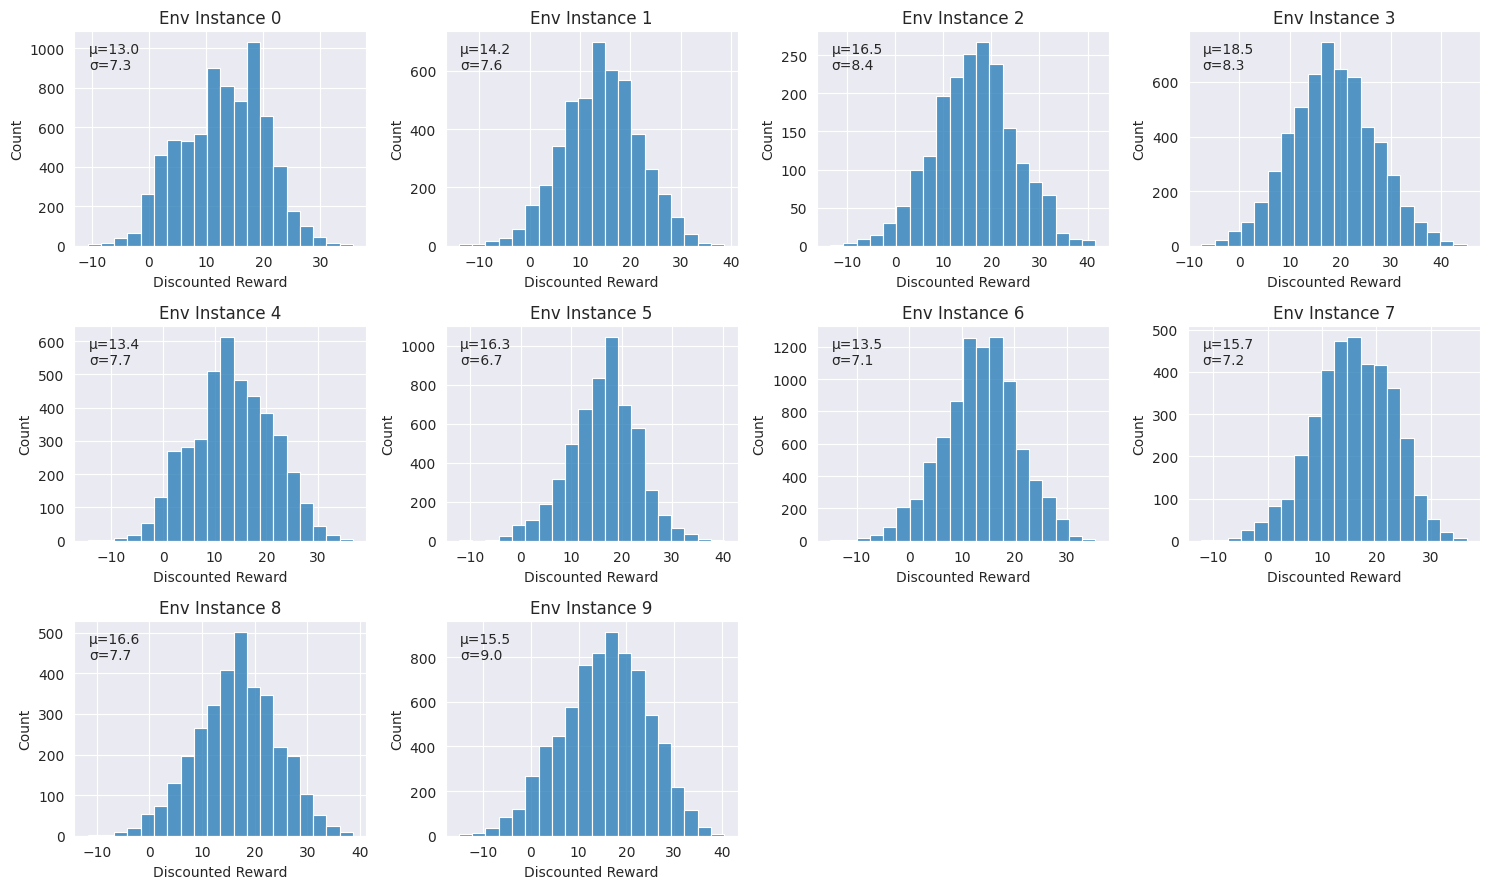


Summary statistics per environment:
                  count       mean       std        min        25%        50%  \
env_instance_id                                                                 
0                7350.0  12.955630  7.283764 -10.708805   7.571601  13.334970   
1                4650.0  14.177892  7.605513 -14.030944   8.940341  14.203759   
2                1950.0  16.484924  8.440772 -13.574050  10.892421  16.583124   
3                5550.0  18.471760  8.335097  -7.545736  12.813806  18.296763   
4                4200.0  13.425069  7.722396 -14.607889   8.334474  13.192584   
5                5550.0  16.282865  6.683648 -12.203702  12.114485  16.814199   
6                8700.0  13.524096  7.134834 -15.005923   9.012473  13.865897   
7                3750.0  15.720226  7.205053 -12.196779  10.939624  15.812078   
8                3300.0  16.648308  7.718731 -11.737328  11.667192  16.956084   
9                7350.0  15.457939  8.985010 -15.047778   9.415827  15.9

In [8]:
# Create a subplot grid based on number of environments
n_envs = len(env_instances_to_analyze)
n_cols = 4  # We can adjust this number to change layout
n_rows = (n_envs + n_cols - 1) // n_cols  # Ceiling division to get required rows

plt.figure(figsize=(15, 3*n_rows))

for idx, env_id in enumerate(env_instances_to_analyze):
    plt.subplot(n_rows, n_cols, idx + 1)
    env_data = df_complete[df_complete['env_instance_id'] == env_id]

    sns.histplot(data=env_data, x='total_discounted_reward', bins=20)
    plt.title(f'Env Instance {env_id}')
    plt.xlabel('Discounted Reward')

    # Add mean and std as text
    mean_reward = env_data['total_discounted_reward'].mean()
    std_reward = env_data['total_discounted_reward'].std()
    plt.text(0.05, 0.95, f'μ={mean_reward:.1f}\nσ={std_reward:.1f}',
             transform=plt.gca().transAxes,
             verticalalignment='top')

plt.tight_layout()
plt.show()

# Print summary statistics for each environment
print("\nSummary statistics per environment:")
print(df_complete.groupby('env_instance_id')['total_discounted_reward'].describe())

# Compute VD and VOA


Value Difference Statistics:
count    16950.000000
mean        -1.631003
std          5.406983
min        -26.468260
25%         -4.696866
50%         -1.158573
75%          1.824188
max         21.298784
Name: value_diff, dtype: float64

Empirical VOA Statistics:
count    339.000000
mean      -1.631003
std        2.976897
min      -10.234485
25%       -3.382182
50%       -1.361832
75%        0.575327
max        5.006569
Name: empirical_voa, dtype: float64


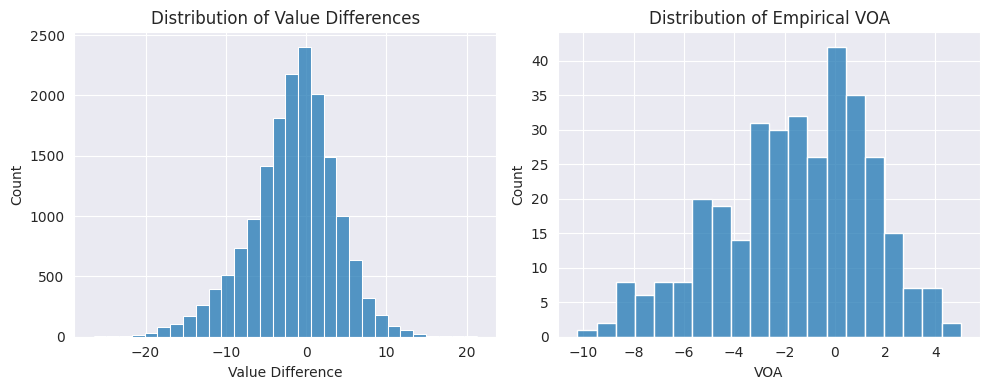


Value Difference Statistics:
count    16950.000000
mean        -1.631003
std          5.406983
min        -26.468260
25%         -4.696866
50%         -1.158573
75%          1.824188
max         21.298784
Name: value_diff, dtype: float64

VOA Statistics:
count    339.000000
mean      -1.631003
std        2.976897
min      -10.234485
25%       -3.382182
50%       -1.361832
75%        0.575327
max        5.006569
Name: empirical_voa, dtype: float64


In [9]:
def compute_value_differences(df):
    # First average across runs for each experiment configuration
    baseline_means = df[df['help_config_id'] == -1].groupby(
        ['env_instance_id', 'state_id'])['total_discounted_reward'].mean().reset_index()

    value_diff_results = []
    for _, baseline_row in baseline_means.iterrows():
        env_instance_id = baseline_row['env_instance_id']
        state_id = baseline_row['state_id']
        baseline_reward = baseline_row['total_discounted_reward']  # This is now mean across runs

        # Get mean rewards for help experiments while preserving help_actions
        help_exps = df[
            (df['env_instance_id'] == env_instance_id) &
            (df['state_id'] == state_id) &
            (df['help_config_id'] != -1)
        ].groupby(['env_instance_id', 'state_id', 'help_config_id']
        ).agg({
            'total_discounted_reward': 'mean',
            'help_actions': 'first',
            'rover_position': 'first',
            'rock_locations': 'first',
            'rock_types': 'first'
        }).reset_index()

        for _, help_row in help_exps.iterrows():
            result_dict = help_row.to_dict()
            result_dict['value_diff'] = help_row['total_discounted_reward'] - baseline_reward
            result_dict['baseline_value'] = baseline_reward
            value_diff_results.append(result_dict)

    return pd.DataFrame(value_diff_results)

def compute_empirical_voa(vd_df):
    # Since states are sampled uniformly, we can just average over states
    # Group by env_instance_id and help_config_id
    voa_results = []

    for (env_id, help_config), group in vd_df.groupby(['env_instance_id', 'help_config_id']):
        # Compute mean value difference (VOA)
        empirical_voa = group['value_diff'].mean()
        # Compute variance
        empirical_variance = group['value_diff'].var()

        voa_results.append({
            'env_instance_id': env_id,
            'help_config_id': help_config,
            'help_actions': group['help_actions'].iloc[0],
            'rover_position': group['rover_position'].iloc[0],
            'rock_locations': group['rock_locations'].iloc[0],
            'empirical_voa': empirical_voa,
            'empirical_voa_variance': empirical_variance,
            'n_states': len(group),
            'baseline_value': group['baseline_value'].mean()
        })

    return pd.DataFrame(voa_results)

vd_df = compute_value_differences(df_complete)
voa_df = compute_empirical_voa(vd_df)

print("\nValue Difference Statistics:")
print(vd_df['value_diff'].describe())

print("\nEmpirical VOA Statistics:")
print(voa_df['empirical_voa'].describe())

plt.figure(figsize=(10, 4))

# Plot 1: Distribution of Value Differences
plt.subplot(121)
sns.histplot(vd_df['value_diff'], bins=30)
plt.title('Distribution of Value Differences')
plt.xlabel('Value Difference')
plt.ylabel('Count')

# Plot 2: Distribution of VOA
plt.subplot(122)
sns.histplot(voa_df['empirical_voa'], bins=20)
plt.title('Distribution of Empirical VOA')
plt.xlabel('VOA')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics
print("\nValue Difference Statistics:")
print(vd_df['value_diff'].describe())
print("\nVOA Statistics:")
print(voa_df['empirical_voa'].describe())

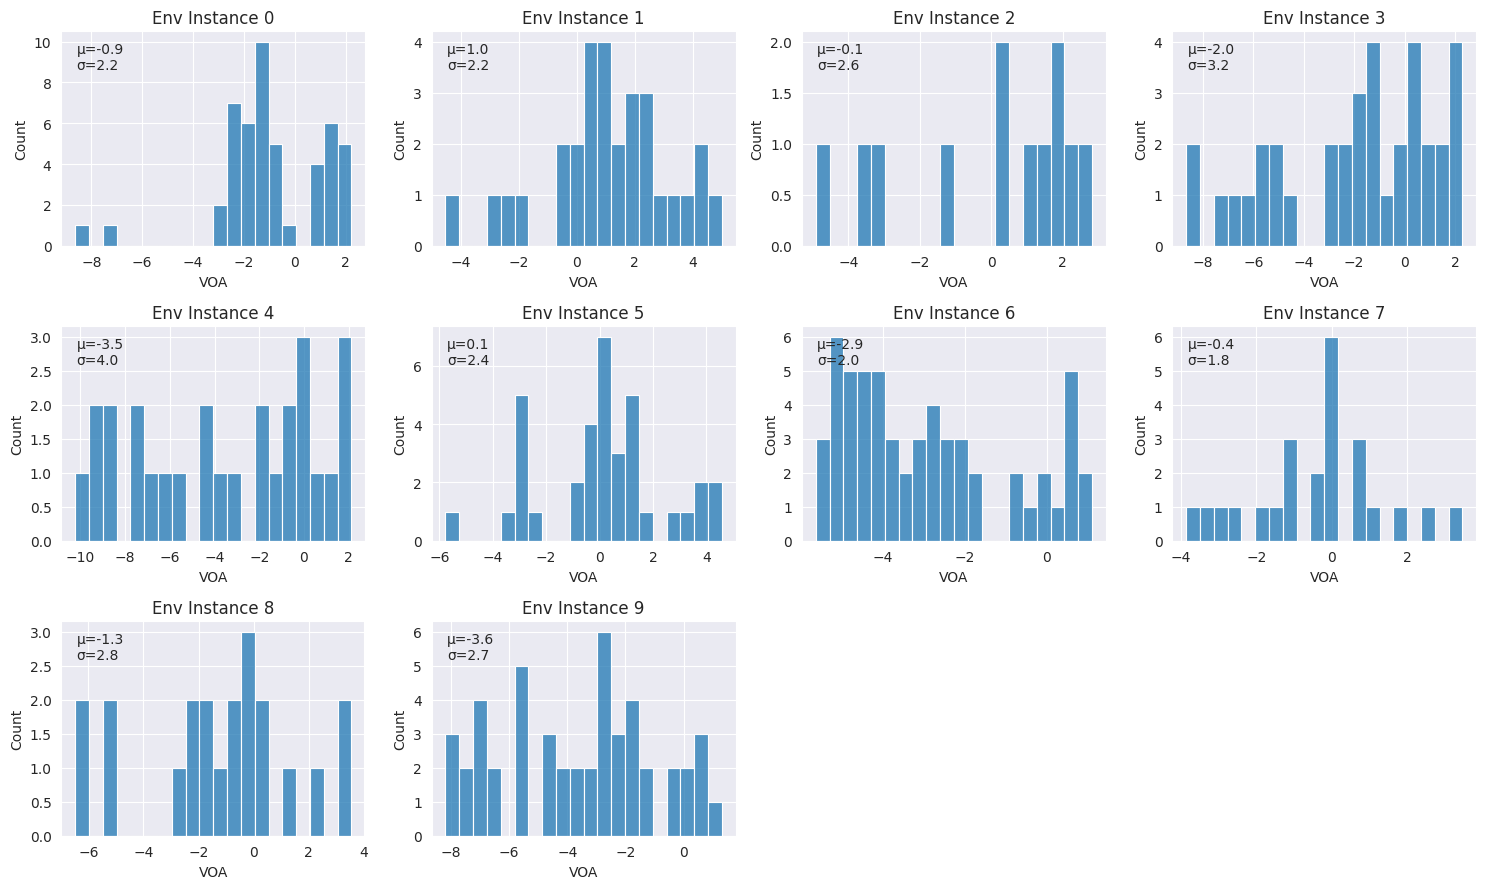


Summary statistics of VOA per environment:
                 count      mean       std        min       25%       50%  \
env_instance_id                                                             
0                 48.0 -0.937873  2.195381  -8.642482 -2.020363 -1.250596   
1                 30.0  1.042947  2.152632  -4.521393  0.197739  0.921393   
2                 12.0 -0.090960  2.570376  -4.914335 -1.639914  0.596608   
3                 36.0 -1.957585  3.185029  -8.674021 -4.868312 -1.384587   
4                 27.0 -3.456993  3.964328 -10.234485 -7.274782 -2.885353   
5                 36.0  0.119528  2.371623  -5.777265 -0.783478  0.131225   
6                 57.0 -2.931678  2.020748  -5.644436 -4.599278 -3.382077   
7                 24.0 -0.399612  1.758039  -3.863497 -1.306560 -0.130089   
8                 21.0 -1.299794  2.846866  -6.480177 -2.306802 -0.862906   
9                 48.0 -3.637249  2.692929  -8.187203 -5.708207 -3.306746   

                      75%      

In [10]:
# Create a subplot grid based on number of environments
n_envs = len(env_instances_to_analyze)
n_cols = 4  # We can adjust this number to change layout
n_rows = (n_envs + n_cols - 1) // n_cols  # Ceiling division to get required rows

plt.figure(figsize=(15, 3*n_rows))

for idx, env_id in enumerate(env_instances_to_analyze):
   plt.subplot(n_rows, n_cols, idx + 1)
   env_data = voa_df[voa_df['env_instance_id'] == env_id]

   sns.histplot(data=env_data, x='empirical_voa', bins=20)
   plt.title(f'Env Instance {env_id}')
   plt.xlabel('VOA')

   # Add mean and std as text
   mean_voa = env_data['empirical_voa'].mean()
   std_voa = env_data['empirical_voa'].std()
   plt.text(0.05, 0.95, f'μ={mean_voa:.1f}\nσ={std_voa:.1f}',
            transform=plt.gca().transAxes,
            verticalalignment='top')

plt.tight_layout()
plt.show()

# Print summary statistics for each environment
print("\nSummary statistics of VOA per environment:")
print(voa_df.groupby('env_instance_id')['empirical_voa'].describe())

# Confidence

In [11]:
def plot_voa_with_standard_errors(voa_df):
    # Compute standard error
    voa_df['std_error'] = np.sqrt(voa_df['empirical_voa_variance'] / voa_df['n_states'])

    plt.figure(figsize=(10, 5))
    # Create labels for each env-help pair
    labels = [f"Env{row['env_instance_id']}-Help{row['help_config_id']}"
             for _, row in voa_df.iterrows()]

    plt.errorbar(range(len(voa_df)), voa_df['empirical_voa'],
                yerr=voa_df['std_error'], fmt='o', alpha=0.5)
    plt.xticks(range(len(voa_df)), labels, rotation=45)
    plt.xlabel('Environment-Help Configuration')
    plt.ylabel('VOA with Standard Error')
    plt.title('VOA with Standard Error Bars')
    plt.tight_layout()
    plt.show()


def plot_bootstrap_confidence_intervals(vd_df, n_bootstrap=1000):
   results = []
   ci_sizes = {'95': [], '90': [], '80': []}

   percentiles = {
       '95': [2.5, 97.5],
       '90': [5, 95],
       '80': [10, 90]
   }

   for (env_id, help_config), group in vd_df.groupby(['env_instance_id', 'help_config_id']):
       boots = [group['value_diff'].sample(n=len(group), replace=True).mean()
               for _ in range(n_bootstrap)]
       mean_voa = group['value_diff'].mean()

       # Calculate CIs for each confidence level
       cis = {}
       ci_size = {}
       for conf_level, percs in percentiles.items():
           ci_low, ci_high = np.percentile(boots, percs)
           cis[conf_level] = (ci_low, ci_high)
           ci_size[conf_level] = ci_high - ci_low
           ci_sizes[conf_level].append(ci_size[conf_level])

       results.append({
           'env_instance_id': env_id,
           'help_config_id': help_config,
           'voa': mean_voa,
           'ci_low_95': cis['95'][0],
           'ci_high_95': cis['95'][1],
           'ci_size_95': ci_size['95'],
           'ci_low_90': cis['90'][0],
           'ci_high_90': cis['90'][1],
           'ci_size_90': ci_size['90'],
           'ci_low_80': cis['80'][0],
           'ci_high_80': cis['80'][1],
           'ci_size_80': ci_size['80']
       })

   results_df = pd.DataFrame(results)

   # Print statistics for each confidence level
   for conf_level in ['95', '90', '80']:
       print(f"\n{conf_level}% Confidence Interval Size Statistics:")
       print(f"Mean CI size: {np.mean(ci_sizes[conf_level]):.2f}")
       print(f"Median CI size: {np.median(ci_sizes[conf_level]):.2f}")
       print(f"Std of CI sizes: {np.std(ci_sizes[conf_level]):.2f}")
       print(f"Min CI size: {np.min(ci_sizes[conf_level]):.2f}")
       print(f"Max CI size: {np.max(ci_sizes[conf_level]):.2f}")

   # Plot with all confidence levels
   plt.figure(figsize=(12, 6))
   labels = [f"Env{row['env_instance_id']}-Help{row['help_config_id']}"
            for _, row in results_df.iterrows()]

   # Plot different confidence intervals with different colors/styles
   plt.errorbar(range(len(results_df)), results_df['voa'],
               yerr=[results_df['voa'] - results_df['ci_low_95'],
                     results_df['ci_high_95'] - results_df['voa']],
               fmt='o', alpha=0.3, color='blue', label='95% CI')
   plt.errorbar(range(len(results_df)), results_df['voa'],
               yerr=[results_df['voa'] - results_df['ci_low_90'],
                     results_df['ci_high_90'] - results_df['voa']],
               fmt='o', alpha=0.5, color='green', label='90% CI')
   plt.errorbar(range(len(results_df)), results_df['voa'],
               yerr=[results_df['voa'] - results_df['ci_low_80'],
                     results_df['ci_high_80'] - results_df['voa']],
               fmt='o', alpha=0.7, color='red', label='80% CI')

   plt.xticks(range(len(results_df)), labels, rotation=45)
   plt.xlabel('Environment-Help Configuration')
   plt.ylabel('VOA with CIs')
   plt.title('VOA with Different Confidence Intervals')
   plt.legend()
   plt.tight_layout()
   plt.show()

   return results_df, ci_sizes

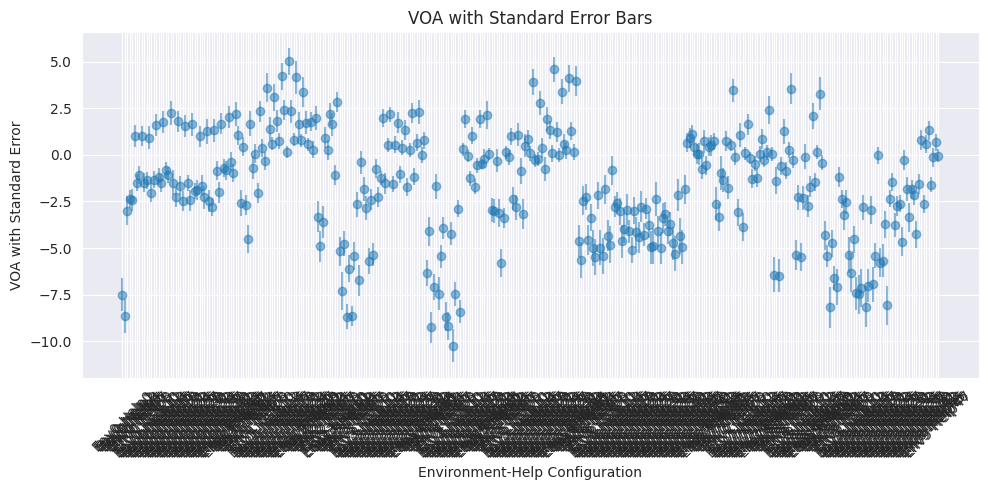

In [12]:
# Plot standard error visualization
plot_voa_with_standard_errors(voa_df)


95% Confidence Interval Size Statistics:
Mean CI size: 2.40
Median CI size: 2.32
Std of CI sizes: 0.67
Min CI size: 1.10
Max CI size: 4.51

90% Confidence Interval Size Statistics:
Mean CI size: 2.02
Median CI size: 1.98
Std of CI sizes: 0.56
Min CI size: 0.94
Max CI size: 3.85

80% Confidence Interval Size Statistics:
Mean CI size: 1.58
Median CI size: 1.53
Std of CI sizes: 0.44
Min CI size: 0.71
Max CI size: 3.00


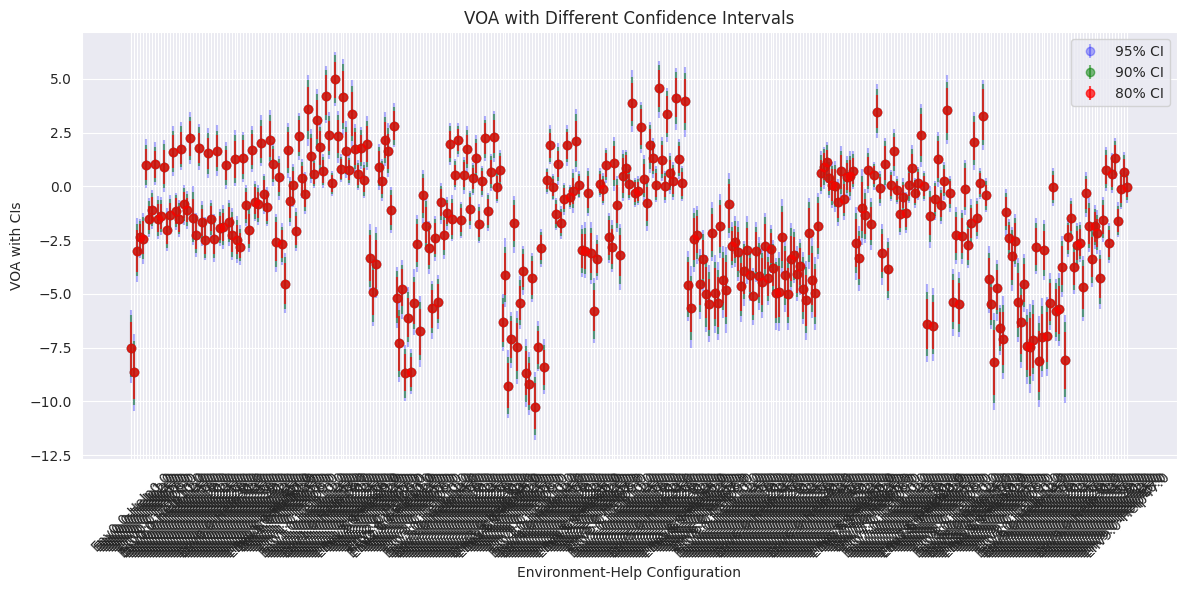

In [13]:
# Plot and get bootstrap CI visualization
bootstrap_results, ci_sizes = plot_bootstrap_confidence_intervals(vd_df, n_bootstrap=1000)

In [14]:
for conf_level in ['95', '90', '80']:
    print(f"\n{conf_level}% Confidence Interval Size Statistics:")
    print(f"Mean CI size: {np.mean(ci_sizes[conf_level]):.2f}")
    print(f"Median CI size: {np.median(ci_sizes[conf_level]):.2f}")
    print(f"Std of CI sizes: {np.std(ci_sizes[conf_level]):.2f}")
    print(f"Min CI size: {np.min(ci_sizes[conf_level]):.2f}")
    print(f"Max CI size: {np.max(ci_sizes[conf_level]):.2f}")


95% Confidence Interval Size Statistics:
Mean CI size: 2.40
Median CI size: 2.32
Std of CI sizes: 0.67
Min CI size: 1.10
Max CI size: 4.51

90% Confidence Interval Size Statistics:
Mean CI size: 2.02
Median CI size: 1.98
Std of CI sizes: 0.56
Min CI size: 0.94
Max CI size: 3.85

80% Confidence Interval Size Statistics:
Mean CI size: 1.58
Median CI size: 1.53
Std of CI sizes: 0.44
Min CI size: 0.71
Max CI size: 3.00


In [15]:
# add the confidence intervals to the voa_df
voa_df = voa_df.merge(bootstrap_results, on=['env_instance_id', 'help_config_id'])

# Huristics

In [16]:
from rocksample_experiments.heuristics import h_first_step_planning_value_diff, h_rollout_policy_value, h_vd_results, h_full_info_planning_value_diff
from rocksample_experiments.heuristics_evaluation import test_heuristic_on_problem_instance, heuristic_metrics, test_heuristic_on_all_instances_parallel, calculate_mean_metrics


In [17]:
def save_test_results(results_dfs_dict, dir_path):
    # make sure the directory exists
    os.makedirs(dir_path, exist_ok=True)
    for i in results_dfs_dict:
        results_dfs_dict[i].to_csv(f'{dir_path}/env{i}.csv')

def load_test_results(dir_path):
    results_dfs_dict = {}
    for file in os.listdir(dir_path):
        if file.endswith(".csv"):
            env_id = int(file.split('env')[1].split('.')[0])
            results_dfs_dict[env_id] = pd.read_csv(f'{dir_path}/{file}', index_col=0)
    return results_dfs_dict

### Baseline mc simulations

In [18]:
n_states = [1, 2, 3, 5, 10, 25, 50]

for n in n_states:
    heuristic_kwargs = {'vd_table': vd_df, 'n_states_to_use': n}
    results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_vd_results, n_jobs=10, heuristic_kwargs=heuristic_kwargs)
    print("--------------------")
    print(f"n_states: {n}")
    print(calculate_mean_metrics(results_dfs_dict))
    print("--------------------")
    # save_test_results(results_dfs_dict, f'heuristics_evaluation/vd_results_n_states_{n}')

--------------------
n_states: 1
{'top_1_accuracy': 0.2, 'top_5_accuracy': 0.44000000000000006, 'rank_correlation': 0.5377470120840727, 'rank_correlation_pvalue': 0.07314498826197914, 'ci_weighted_correlation': 0.5636661821550798, 'rank_of_best_heuristic': 6.9, 'voa_of_best_heuristic': 1.3341803124366707, 'mean_computation_time': 0.01695260852732986, 'std_computation_time': 0.010928355581185873, 'max_computation_time': 0.050622963905334474, 'min_computation_time': 0.010246825218200684, 'sign_precision': 0.5537745098039215, 'sign_recall': 0.7006862745098039, 'sign_accuracy': 0.7369817761281177, 'sign_balanced_accuracy': 0.7339471748295276, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.4, 'sign_n_significant_negative': 18.4, 'n_environments': 10}
--------------------
--------------------
n_states: 2
{'top_1_accuracy': 0.2, 'top_5_accuracy': 0.4800000000000001, 'rank_correlation': 0.6844532701672428, 'rank_correlation_pvalue': 0.00814096220188536, 'ci_

### First step planning value difference

uncomment to recalculate:

In [19]:
# Uncomment to recalculate
#
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_first_step_planning_value_diff, n_jobs=10)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/first_step_planning')

# heuristic_kwargs = {'n_trials': 5}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_first_step_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/first_step_planning_5_trials')
#
# heuristic_kwargs = {'n_trials': 10}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_first_step_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/first_step_planning_10_trials')
#
# heuristic_kwargs = {'n_sims': 10000, 'max_depth': 100}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_first_step_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/first_step_planning_10000_sims_100_depth')


In [20]:
results_plain_first_step_planning = load_test_results('heuristics_evaluation/first_step_planning')
print(calculate_mean_metrics(results_plain_first_step_planning))

{'top_1_accuracy': 0.2, 'top_5_accuracy': 0.42000000000000004, 'rank_correlation': 0.5904693866681923, 'rank_correlation_pvalue': 0.0645100197934538, 'ci_weighted_correlation': 0.5436652945432436, 'rank_of_best_heuristic': 8.1, 'voa_of_best_heuristic': 0.9513529595914072, 'mean_computation_time': 2.679759649916699, 'std_computation_time': 0.5427419757912386, 'max_computation_time': 4.2585890054702755, 'min_computation_time': 2.219389462471008, 'sign_precision': 0.47686260248179757, 'sign_recall': 1.0, 'sign_accuracy': 0.6711380579673263, 'sign_balanced_accuracy': 0.7602180417621593, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [21]:
results_first_step_planning_5_trials = load_test_results('heuristics_evaluation/first_step_planning_5_trials')
print(calculate_mean_metrics(results_first_step_planning_5_trials))


{'top_1_accuracy': 0.2, 'top_5_accuracy': 0.32, 'rank_correlation': 0.5676157479061734, 'rank_correlation_pvalue': 0.05212322966363534, 'ci_weighted_correlation': 0.549643776328096, 'rank_of_best_heuristic': 9.6, 'voa_of_best_heuristic': 0.9292827814047199, 'mean_computation_time': 14.29659274543819, 'std_computation_time': 3.095007303519633, 'max_computation_time': 25.137559008598327, 'min_computation_time': 11.291236734390258, 'sign_precision': 0.4637202380952381, 'sign_recall': 1.0, 'sign_accuracy': 0.6409353519109617, 'sign_balanced_accuracy': 0.7322765469824294, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [22]:
results_first_step_planning_10_trials = load_test_results('heuristics_evaluation/first_step_planning_10_trials')
print(calculate_mean_metrics(results_first_step_planning_10_trials))

{'top_1_accuracy': 0.2, 'top_5_accuracy': 0.42000000000000004, 'rank_correlation': 0.5768638590561218, 'rank_correlation_pvalue': 0.05766228692422766, 'ci_weighted_correlation': 0.5617705335214463, 'rank_of_best_heuristic': 10.8, 'voa_of_best_heuristic': 0.6431677798420846, 'mean_computation_time': 25.944221111928908, 'std_computation_time': 4.229926876830563, 'max_computation_time': 38.44779012203217, 'min_computation_time': 21.709925889968872, 'sign_precision': 0.4620666585819387, 'sign_recall': 1.0, 'sign_accuracy': 0.6394538704294802, 'sign_balanced_accuracy': 0.7310319582378406, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [23]:
results_first_step_planning_10000_sims_100_depth = load_test_results('heuristics_evaluation/first_step_planning_10000_sims_100_depth')
print(calculate_mean_metrics(results_first_step_planning_10000_sims_100_depth))

{'top_1_accuracy': 0.4, 'top_5_accuracy': 0.5799999999999998, 'rank_correlation': 0.6926582893414988, 'rank_correlation_pvalue': 0.0029628161156134637, 'ci_weighted_correlation': 0.6897643584088288, 'rank_of_best_heuristic': 5.3, 'voa_of_best_heuristic': 1.8684631955305762, 'mean_computation_time': 66.34995228729227, 'std_computation_time': 10.54541847314574, 'max_computation_time': 92.78889815807342, 'min_computation_time': 54.358905005455014, 'sign_precision': 0.4403347383610542, 'sign_recall': 0.9, 'sign_accuracy': 0.64067784970224, 'sign_balanced_accuracy': 0.6915275655716833, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


### Rollout policy value

In [24]:
# Uncomment to recalculate

# heuristic_kwargs = {'n_rollouts': 10}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_rollout_policy_value, n_jobs=10,
#                                                             heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/rollout_policy_value_10_rollouts')
#
# heuristic_kwargs = {'n_rollouts': 100}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_rollout_policy_value, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/rollout_policy_value_100_rollouts')
#
# heuristic_kwargs = {'n_rollouts': 1000}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_rollout_policy_value, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/rollout_policy_value_1000_rollouts')

In [25]:
results_rollout_policy_value_10_rollouts = load_test_results('heuristics_evaluation/rollout_policy_value_10_rollouts')
print(calculate_mean_metrics(results_rollout_policy_value_10_rollouts))

{'top_1_accuracy': 0.1, 'top_5_accuracy': 0.18, 'rank_correlation': -0.029347385605251426, 'rank_correlation_pvalue': 0.3952067022174943, 'ci_weighted_correlation': -0.04553615264105713, 'rank_of_best_heuristic': 21.3, 'voa_of_best_heuristic': -2.460095009388219, 'mean_computation_time': 0.06888903615261242, 'std_computation_time': 0.015134221491579104, 'max_computation_time': 0.10839068889617913, 'min_computation_time': 0.058523416519165004, 'sign_precision': 0.344981684981685, 'sign_recall': 0.4424866310160428, 'sign_accuracy': 0.5296430850089385, 'sign_balanced_accuracy': 0.4787477718360071, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [26]:
results_rollout_policy_value_100_rollouts = load_test_results('heuristics_evaluation/rollout_policy_value_100_rollouts')
print(calculate_mean_metrics(results_rollout_policy_value_100_rollouts))


{'top_1_accuracy': 0.0, 'top_5_accuracy': 0.18, 'rank_correlation': -0.05368422928538917, 'rank_correlation_pvalue': 0.3641778634965117, 'ci_weighted_correlation': -0.07597716281807246, 'rank_of_best_heuristic': 12.1, 'voa_of_best_heuristic': -0.3135177278917346, 'mean_computation_time': 0.7006465917790011, 'std_computation_time': 0.14970972326034454, 'max_computation_time': 1.1603804111480713, 'min_computation_time': 0.5220946788787841, 'sign_precision': 0.30271001944914994, 'sign_recall': 0.566729055258467, 'sign_accuracy': 0.46896069603386675, 'sign_balanced_accuracy': 0.5035090399796281, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [27]:
results_rollout_policy_value_1000_rollouts = load_test_results('heuristics_evaluation/rollout_policy_value_1000_rollouts')
print(calculate_mean_metrics(results_rollout_policy_value_1000_rollouts))

{'top_1_accuracy': 0.0, 'top_5_accuracy': 0.1, 'rank_correlation': -0.12575766484662468, 'rank_correlation_pvalue': 0.2849207018787203, 'ci_weighted_correlation': -0.16541899534436447, 'rank_of_best_heuristic': 24.3, 'voa_of_best_heuristic': -2.2701699800095048, 'mean_computation_time': 6.858864616565105, 'std_computation_time': 1.2528052126128475, 'max_computation_time': 10.644571113586426, 'min_computation_time': 5.701404881477356, 'sign_precision': 0.21330128205128202, 'sign_recall': 0.30825311942959005, 'sign_accuracy': 0.4837469305761989, 'sign_balanced_accuracy': 0.42363031576266863, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


### planning with full information

In [28]:
# # Uncomment to recalculate
#
# heuristic_kwargs = {'n_states': 1}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_full_info_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/full_info_planning_n_states_1')
#
# heuristic_kwargs = {'n_states': 5}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_full_info_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/full_info_planning_n_states_5')
#
# heuristic_kwargs = {'n_states': 50}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_full_info_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/full_info_planning_n_states_50')
#
# heuristic_kwargs = {'n_states': 200}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_full_info_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/full_info_planning_n_states_200')
#
# heuristic_kwargs = {'n_states': 1000}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_full_info_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/full_info_planning_n_states_1000')

# heuristic_kwargs = {'n_states': 2000}
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_full_info_planning_value_diff, n_jobs=10
#                                                             , heuristic_kwargs=heuristic_kwargs)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/full_info_planning_n_states_2000')

In [29]:
results_full_info_planning_n_states_1 = load_test_results('heuristics_evaluation/full_info_planning_n_states_1')
print(calculate_mean_metrics(results_full_info_planning_n_states_1))

{'top_1_accuracy': 0.1, 'top_5_accuracy': 0.4, 'rank_correlation': 0.47670859181031755, 'rank_correlation_pvalue': 0.12039902345513047, 'ci_weighted_correlation': 0.43214816570596, 'rank_of_best_heuristic': 10.9, 'voa_of_best_heuristic': 0.5241116774808374, 'mean_computation_time': 0.01602953922496266, 'std_computation_time': 0.012432332156267354, 'max_computation_time': 0.05303566455841059, 'min_computation_time': 0.0087880134582519, 'sign_precision': 0.39699086354258767, 'sign_recall': 0.8024509803921568, 'sign_accuracy': 0.6172721091013774, 'sign_balanced_accuracy': 0.618876050420168, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [30]:
results_full_info_planning_n_states_5 = load_test_results('heuristics_evaluation/full_info_planning_n_states_5')
print(calculate_mean_metrics(results_full_info_planning_n_states_5))

{'top_1_accuracy': 0.1, 'top_5_accuracy': 0.5, 'rank_correlation': 0.6316173975499753, 'rank_correlation_pvalue': 0.007378582638243804, 'ci_weighted_correlation': 0.6097713528886757, 'rank_of_best_heuristic': 6.4, 'voa_of_best_heuristic': 1.5354869635524886, 'mean_computation_time': 0.016024869036471948, 'std_computation_time': 0.011385988506581355, 'max_computation_time': 0.04989035129547115, 'min_computation_time': 0.00899422168731684, 'sign_precision': 0.37661686896981006, 'sign_recall': 1.0, 'sign_accuracy': 0.5199005691688618, 'sign_balanced_accuracy': 0.638115291571174, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [31]:
results_full_info_planning_n_states_50 = load_test_results('heuristics_evaluation/full_info_planning_n_states_50')
print(calculate_mean_metrics(results_full_info_planning_n_states_50))

{'top_1_accuracy': 0.6, 'top_5_accuracy': 0.6399999999999999, 'rank_correlation': 0.719905565207035, 'rank_correlation_pvalue': 0.0006977658824943117, 'ci_weighted_correlation': 0.695104309308557, 'rank_of_best_heuristic': 4.7, 'voa_of_best_heuristic': 2.1273266658497483, 'mean_computation_time': 0.02139650466647259, 'std_computation_time': 0.012192208416508709, 'max_computation_time': 0.05273497104644771, 'min_computation_time': 0.013466501235961858, 'sign_precision': 0.36860022652785807, 'sign_recall': 1.0, 'sign_accuracy': 0.5078239240434363, 'sign_balanced_accuracy': 0.6258642093200916, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [32]:
results_full_info_planning_n_states_200 = load_test_results('heuristics_evaluation/full_info_planning_n_states_200')
print(calculate_mean_metrics(results_full_info_planning_n_states_200))

{'top_1_accuracy': 0.5, 'top_5_accuracy': 0.7, 'rank_correlation': 0.7324514047785556, 'rank_correlation_pvalue': 0.0006712806692095195, 'ci_weighted_correlation': 0.7098204639018466, 'rank_of_best_heuristic': 2.7, 'voa_of_best_heuristic': 2.4150368443430574, 'mean_computation_time': 0.03936532356353294, 'std_computation_time': 0.014350792430927784, 'max_computation_time': 0.06827187538146967, 'min_computation_time': 0.027100753784179643, 'sign_precision': 0.375145757020757, 'sign_recall': 1.0, 'sign_accuracy': 0.5216558328753451, 'sign_balanced_accuracy': 0.6380665902724727, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [33]:
results_full_info_planning_n_states_1000 = load_test_results('heuristics_evaluation/full_info_planning_n_states_1000')
print(calculate_mean_metrics(results_full_info_planning_n_states_1000))

{'top_1_accuracy': 0.6, 'top_5_accuracy': 0.7, 'rank_correlation': 0.7382503179188679, 'rank_correlation_pvalue': 0.0006359211697185198, 'ci_weighted_correlation': 0.708111883384817, 'rank_of_best_heuristic': 2.4, 'voa_of_best_heuristic': 2.5551637067219732, 'mean_computation_time': 0.13215899367122985, 'std_computation_time': 0.023075635052718042, 'max_computation_time': 0.18982276916503904, 'min_computation_time': 0.10324885845184321, 'sign_precision': 0.37906732564820794, 'sign_recall': 1.0, 'sign_accuracy': 0.5266558328753451, 'sign_balanced_accuracy': 0.6443165902724727, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [34]:
results_full_info_planning_n_states_2000 = load_test_results('heuristics_evaluation/full_info_planning_n_states_2000')
print(calculate_mean_metrics(results_full_info_planning_n_states_2000))


{'top_1_accuracy': 0.6, 'top_5_accuracy': 0.6799999999999999, 'rank_correlation': 0.7370485203413005, 'rank_correlation_pvalue': 0.0006260681836754813, 'ci_weighted_correlation': 0.7109259957967234, 'rank_of_best_heuristic': 2.5, 'voa_of_best_heuristic': 2.5014380884702567, 'mean_computation_time': 0.25730672610674155, 'std_computation_time': 0.045663396010312274, 'max_computation_time': 0.38532247543334963, 'min_computation_time': 0.20275537967681884, 'sign_precision': 0.375145757020757, 'sign_recall': 1.0, 'sign_accuracy': 0.5216558328753451, 'sign_balanced_accuracy': 0.6380665902724727, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


In [35]:
# from rocksample_experiments.heuristics import h_full_info_planning_value_all_states
# results_dfs_dict = test_heuristic_on_all_instances_parallel(voa_df, h_full_info_planning_value_all_states, n_jobs=10)
# save_test_results(results_dfs_dict, 'heuristics_evaluation/full_info_planning_all_states')

In [36]:
results_full_info_planning_all_states = load_test_results('heuristics_evaluation/full_info_planning_all_states')
print(calculate_mean_metrics(results_full_info_planning_all_states))

{'top_1_accuracy': 0.7, 'top_5_accuracy': 0.6799999999999999, 'rank_correlation': 0.7417314944825113, 'rank_correlation_pvalue': 0.0004322496975770496, 'ci_weighted_correlation': 0.708872400469843, 'rank_of_best_heuristic': 2.2, 'voa_of_best_heuristic': 2.6412571674189027, 'mean_computation_time': 0.2367766865771715, 'std_computation_time': 0.02952131595826335, 'max_computation_time': 0.30201566219329834, 'min_computation_time': 0.1938602209091186, 'sign_precision': 0.37500330687830685, 'sign_recall': 1.0, 'sign_accuracy': 0.5192168084851012, 'sign_balanced_accuracy': 0.6368165902724726, 'sign_n_significant': 24.8, 'sign_n_total': 33.9, 'sign_n_significant_positive': 6.3, 'sign_n_significant_negative': 18.5, 'n_environments': 10}


--------------------------